# Chapter 12. Monsters and Mixtures

In [1]:
import math
import os

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import set_matplotlib_formats

import jax.numpy as jnp
from jax import lax, random
from jax.scipy.special import expit

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.distributions.transforms import OrderedTransform
from numpyro.infer import ELBO, MCMC, NUTS, SVI, Predictive, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
numpyro.set_host_device_count(4)

### Code 12.1

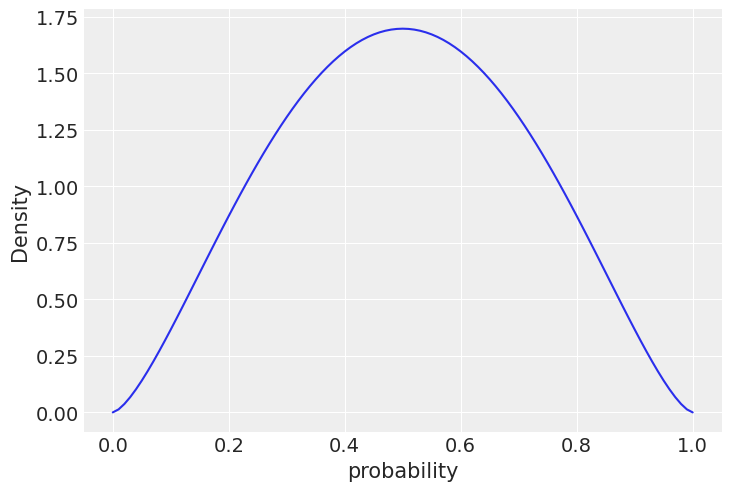

In [2]:
pbar = 0.5
theta = 5
x = jnp.linspace(0, 1, 101)
plt.plot(x, jnp.exp(dist.Beta(pbar * theta, (1 - pbar) * theta).log_prob(x)))
plt.gca().set(xlabel="probability", ylabel="Density")
plt.show()

### Code 12.2

In [3]:
UCBadmit = pd.read_csv("../data/UCBadmit.csv", sep=";")
d = UCBadmit
d["gid"] = (d["applicant.gender"] != "male").astype(int)
dat = dict(A=d.admit.values, N=d.applications.values, gid=d.gid.values)


def model(gid, N, A=None):
    a = numpyro.sample("a", dist.Normal(0, 1.5).expand([2]))
    phi = numpyro.sample("phi", dist.Exponential(1))
    theta = numpyro.deterministic("theta", phi + 2)
    pbar = expit(a[gid])
    numpyro.sample("A", dist.BetaBinomial(pbar * theta, (1 - pbar) * theta, N), obs=A)


m12_1 = MCMC(NUTS(model), 500, 500, num_chains=4)
m12_1.run(random.PRNGKey(0), **dat)

### Code 12.3

In [4]:
post = m12_1.get_samples()
post["theta"] = Predictive(m12_1.sampler.model, post)(random.PRNGKey(1), **dat)["theta"]
post["da"] = post["a"][:, 0] - post["a"][:, 1]
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]     -0.45      0.42     -0.43     -1.13      0.22   1548.69      1.01
      a[1]     -0.29      0.44     -0.29     -1.00      0.37   1753.57      1.00
        da     -0.16      0.61     -0.15     -1.08      0.83   1800.24      1.00
       phi      1.05      0.79      0.88      0.01      2.07   1784.74      1.00
     theta      3.05      0.79      2.88      2.01      4.07   1784.74      1.00



### Code 12.4

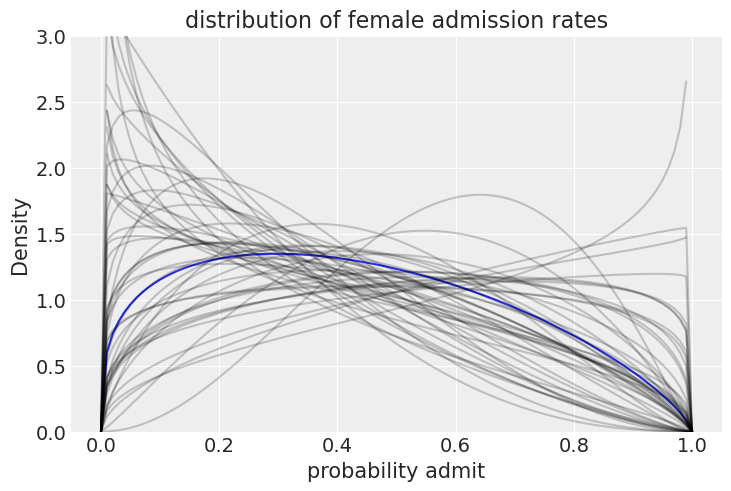

In [5]:
gid = 1
# draw posterior mean beta distribution
x = jnp.linspace(0, 1, 101)
pbar = jnp.mean(expit(post["a"][:, gid]))
theta = jnp.mean(post["theta"])
plt.plot(x, jnp.exp(dist.Beta(pbar * theta, (1 - pbar) * theta).log_prob(x)))
plt.gca().set(ylabel="Density", xlabel="probability admit", ylim=(0, 3))

# draw 50 beta distributions sampled from posterior
for i in range(50):
    p = expit(post["a"][i, gid])
    theta = post["theta"][i]
    plt.plot(
        x, jnp.exp(dist.Beta(p * theta, (1 - p) * theta).log_prob(x)), "k", alpha=0.2
    )
plt.title("distribution of female admission rates")
plt.show()

### Code 12.5

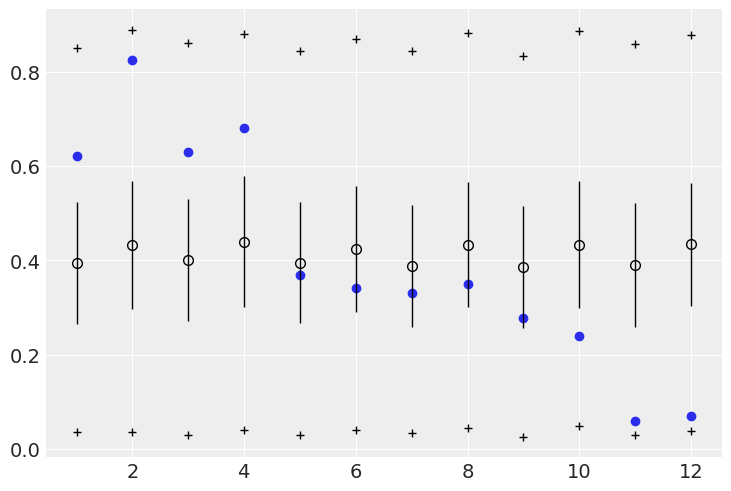

In [6]:
post = m12_1.get_samples()
admit_pred = Predictive(m12_1.sampler.model, post)(
    random.PRNGKey(1), gid=dat["gid"], N=dat["N"]
)["A"]
admit_rate = admit_pred / dat["N"]
plt.scatter(range(1, 13), dat["A"] / dat["N"])
plt.errorbar(
    range(1, 13),
    jnp.mean(admit_rate, 0),
    jnp.std(admit_rate, 0) / 2,
    fmt="o",
    c="k",
    mfc="none",
    ms=7,
    elinewidth=1,
)
plt.plot(range(1, 13), jnp.percentile(admit_rate, 5.5, 0), "k+")
plt.plot(range(1, 13), jnp.percentile(admit_rate, 94.5, 0), "k+")
plt.show()

### Code 12.6

In [7]:
Kline = pd.read_csv("../data/Kline.csv", sep=";")
d = Kline
d["P"] = d.population.apply(math.log).pipe(lambda x: (x - x.mean()) / x.std())
d["contact_id"] = (d.contact == "high").astype(int)

dat2 = dict(T=d.total_tools.values, P=d.population.values, cid=d.contact_id.values)


def model(cid, P, T):
    a = numpyro.sample("a", dist.Normal(1, 1).expand([2]))
    b = numpyro.sample("b", dist.Exponential(1).expand([2]))
    g = numpyro.sample("g", dist.Exponential(1))
    phi = numpyro.sample("phi", dist.Exponential(1))
    lambda_ = jnp.exp(a[cid]) * jnp.power(P, b[cid]) / g
    numpyro.sample("T", dist.GammaPoisson(lambda_ / phi, 1 / phi), obs=T)


m12_2 = MCMC(NUTS(model), 500, 500, num_chains=4)
m12_2.run(random.PRNGKey(0), **dat2)

### Code 12.7

In [8]:
# define parameters
prob_drink = 0.2  # 20% of days
rate_work = 1  # average 1 manuscript per day

# sample one year of production
N = 365

with numpyro.handlers.seed(rng_seed=365):
    # simulate days monks drink
    drink = numpyro.sample("drink", dist.Binomial(1, prob_drink).expand([N]))

    # simulate manuscripts completed
    y = (1 - drink) * numpyro.sample("work", dist.Poisson(rate_work).expand([N]))

### Code 12.8

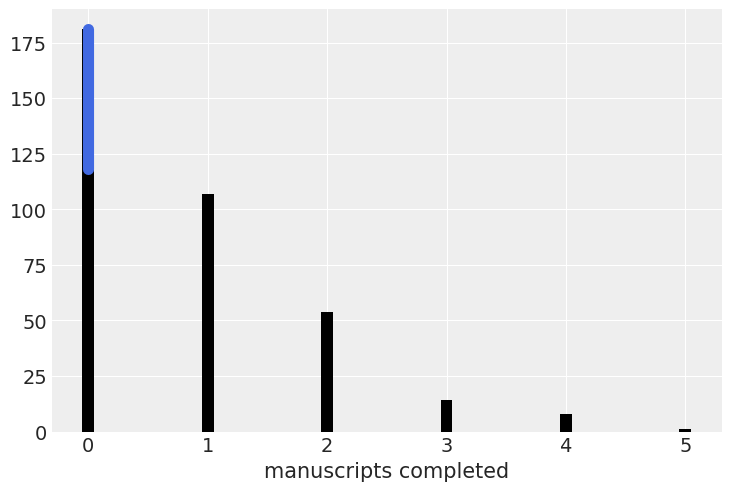

In [9]:
plt.hist(y, color="k", bins=jnp.arange(-0.5, 6), rwidth=0.1)
plt.gca().set(xlabel="manuscripts completed")
zeros_drink = jnp.sum(drink)
zeros_work = jnp.sum((y == 0) & (drink == 0))
zeros_total = jnp.sum(y == 0)
plt.plot([0, 0], [zeros_work, zeros_total], "royalblue", lw=8)
plt.show()

### Code 12.9

In [10]:
def model(y):
    ap = numpyro.sample("ap", dist.Normal(-1.5, 1))
    al = numpyro.sample("al", dist.Normal(1, 0.5))
    p = expit(ap)
    lambda_ = jnp.exp(al)
    numpyro.sample("y", dist.ZeroInflatedPoisson(p, lambda_), obs=y)


m12_3 = MCMC(NUTS(model), 500, 500, num_chains=4)
m12_3.run(random.PRNGKey(0), y=y)
m12_3.print_summary(0.89)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        al      0.03      0.09      0.03     -0.11      0.16    600.93      1.01
        ap     -1.36      0.35     -1.33     -1.87     -0.80    545.76      1.01

Number of divergences: 0


### Code 12.10

In [11]:
post = m12_3.get_samples()
print(jnp.mean(expit(post["ap"])))  # probability drink
print(jnp.mean(jnp.exp(post["al"])))  # rate finish manuscripts, when not drinking

0.20937906
1.0373805


### Code 12.11

In [12]:
def model(y):
    ap = numpyro.sample("ap", dist.Normal(-1.5, 1))
    al = numpyro.sample("al", dist.Normal(1, 0.5))
    p = expit(ap)
    lambda_ = jnp.exp(al)
    log_prob = jnp.log1p(-p) + dist.Poisson(lambda_).log_prob(y)
    numpyro.factor("y|y>0", log_prob[y > 0])
    numpyro.factor("y|y==0", jnp.logaddexp(jnp.log(p), log_prob[y == 0]))


m12_3_alt = MCMC(NUTS(model), 500, 500, num_chains=4)
m12_3_alt.run(random.PRNGKey(0), y=y)
m12_3_alt.print_summary(0.89)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        al      0.03      0.09      0.03     -0.09      0.18    556.80      1.01
        ap     -1.37      0.37     -1.33     -1.83     -0.79    497.71      1.01

Number of divergences: 0


### Code 12.12

In [13]:
Trolley = pd.read_csv("../data/Trolley.csv", sep=";")
d = Trolley

### Code 12.13

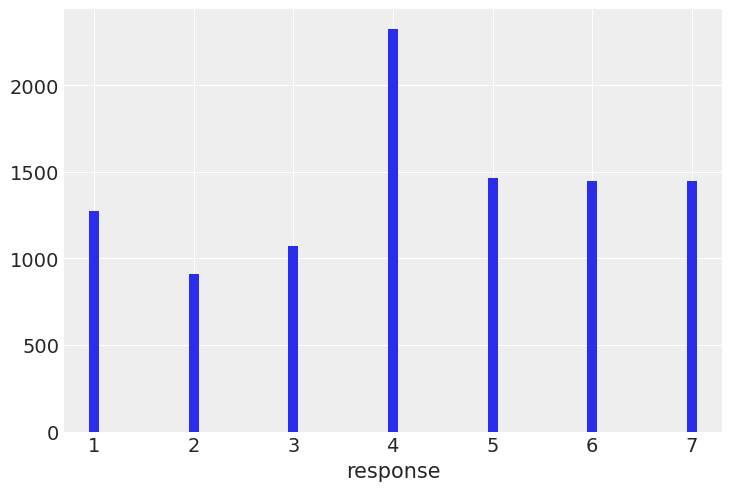

In [14]:
plt.hist(d.response, bins=jnp.arange(0.5, 8), rwidth=0.1)
plt.gca().set(xlim=(0.7, 7.3), xlabel="response")
plt.show()

### Code 12.14

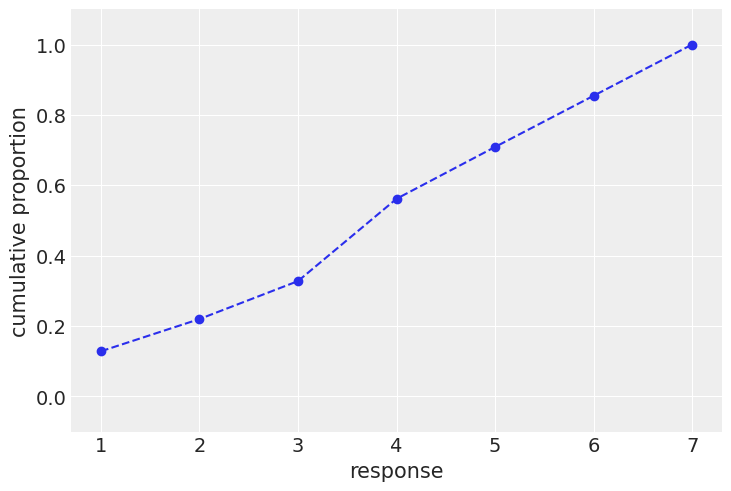

In [15]:
# discrete proportion of each response value
pr_k = d.response.value_counts().sort_index().values / d.shape[0]

# cumsum converts to cumulative proportions
cum_pr_k = jnp.cumsum(pr_k, -1)

# plot
plt.plot(range(1, 8), cum_pr_k, "--o")
plt.gca().set(xlabel="response", ylabel="cumulative proportion", ylim=(-0.1, 1.1))
plt.show()

### Code 12.15

In [16]:
logit = lambda x: jnp.log(x / (1 - x))  # convenience function
lco = logit(cum_pr_k)
lco

DeviceArray([-1.9160911 , -1.2666056 , -0.71863407,  0.24778582,
              0.8898638 ,  1.7693809 ,         inf], dtype=float32)

### Code 12.16

In [17]:
def model(R):
    cutpoints = numpyro.sample(
        "cutpoints",
        dist.TransformedDistribution(
            dist.Normal(jnp.zeros(6), 1.5), OrderedTransform()
        ),
    )
    numpyro.sample("R", dist.OrderedLogistic(0, cutpoints), obs=R)


m12_4 = MCMC(NUTS(model), 500, 500, num_chains=4)
m12_4.run(random.PRNGKey(42), R=d.response.values - 1)

### Code 12.17

In [18]:
def model(response):
    cutpoints = numpyro.sample(
        "cutpoints",
        dist.TransformedDistribution(
            dist.Normal(jnp.zeros(6), 1.5), OrderedTransform()
        ),
    )
    numpyro.sample("response", dist.OrderedLogistic(0, cutpoints), obs=response)


m12_4q = AutoLaplaceApproximation(
    model,
    init_strategy=init_to_value(
        values={"cutpoints": jnp.array([-2, -1, 0, 1, 2, 2.5])}
    ),
)
svi = SVI(model, m12_4q, optim.Adam(0.3), ELBO(), response=d.response.values - 1)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p12_4q = svi.get_params(state)

### Code 12.18

In [19]:
m12_4.print_summary(0.89)


                  mean       std    median      5.5%     94.5%     n_eff     r_hat
cutpoints[0]     -1.44      0.82     -1.90     -1.95     -0.03      2.00     34.59
cutpoints[1]     -0.15      1.93     -1.26     -1.29      3.18      2.00    101.07
cutpoints[2]      1.56      3.95     -0.71     -0.74      8.40      2.00    235.67
cutpoints[3]      3.08      4.91      0.26      0.23     11.58      2.00    313.43
cutpoints[4]      3.62      4.72      0.90      0.87     11.79      2.00    269.79
cutpoints[5]      4.43      4.61      1.78      1.74     12.40      2.00    206.71

Number of divergences: 0


### Code 12.19

In [20]:
expit(jnp.mean(m12_4.get_samples()["cutpoints"], 0))

DeviceArray([0.19098978, 0.46144995, 0.82639164, 0.95608157, 0.9737887 ,
             0.98820484], dtype=float32)

### Code 12.20

In [21]:
coef = jnp.mean(m12_4.get_samples()["cutpoints"], 0)
pk = jnp.exp(dist.OrderedLogistic(0, coef).log_prob(jnp.arange(7)))
pk

DeviceArray([0.19098976, 0.2704602 , 0.36494166, 0.12968995, 0.01770711,
             0.01441616, 0.01179516], dtype=float32)

### Code 12.21

In [22]:
jnp.sum(pk * jnp.arange(1, 8))

DeviceArray(2.6030934, dtype=float32)

### Code 12.22

In [23]:
coef = jnp.mean(m12_4.get_samples()["cutpoints"], 0) - 0.5
pk = jnp.exp(dist.OrderedLogistic(0, coef).log_prob(jnp.arange(7)))
pk

DeviceArray([0.12525381, 0.21672083, 0.40076688, 0.18685508, 0.02791077,
             0.02319336, 0.01929927], dtype=float32)

### Code 12.23

In [24]:
jnp.sum(pk * jnp.arange(1, 8))

DeviceArray(2.9222252, dtype=float32)

### Code 12.24

In [25]:
dat = dict(
    R=d.response.values - 1, A=d.action.values, I=d.intention.values, C=d.contact.values
)


def model(A, I, C, R=None):
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    bI = numpyro.sample("bI", dist.Normal(0, 0.5))
    bC = numpyro.sample("bC", dist.Normal(0, 0.5))
    bIA = numpyro.sample("bIA", dist.Normal(0, 0.5))
    bIC = numpyro.sample("bIC", dist.Normal(0, 0.5))
    cutpoints = numpyro.sample(
        "cutpoints",
        dist.TransformedDistribution(
            dist.Normal(jnp.zeros(6), 1.5), OrderedTransform()
        ),
    )
    BI = bI + bIA * A + bIC * C
    phi = numpyro.deterministic("phi", bA * A + bC * C + BI * I)
    numpyro.sample("R", dist.OrderedLogistic(phi, cutpoints), obs=R)


m12_5 = MCMC(NUTS(model), 500, 500, num_chains=4)
m12_5.run(random.PRNGKey(0), **dat)
m12_5.print_summary(0.89)


                  mean       std    median      5.5%     94.5%     n_eff     r_hat
          bA     -0.47      0.05     -0.47     -0.56     -0.39    935.71      1.00
          bC     -0.35      0.07     -0.35     -0.45     -0.23   1033.59      1.00
          bI     -0.29      0.06     -0.29     -0.39     -0.21    853.43      1.00
         bIA     -0.43      0.08     -0.43     -0.56     -0.31    988.97      1.00
         bIC     -1.23      0.10     -1.23     -1.40     -1.09   1086.57      1.00
cutpoints[0]     -2.63      0.05     -2.63     -2.72     -2.55    928.31      1.00
cutpoints[1]     -1.94      0.05     -1.94     -2.02     -1.87    918.56      1.00
cutpoints[2]     -1.34      0.05     -1.34     -1.42     -1.27    910.91      1.00
cutpoints[3]     -0.31      0.04     -0.31     -0.38     -0.24    917.37      1.00
cutpoints[4]      0.36      0.04      0.36      0.29      0.43    955.12      1.00
cutpoints[5]      1.27      0.05      1.27      1.19      1.34   1079.28      1.00

Nu

### Code 12.25

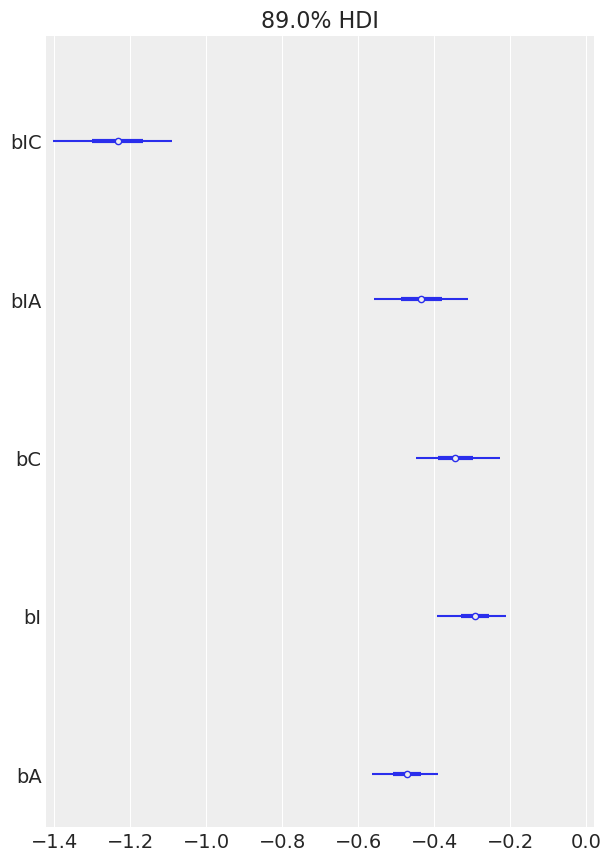

In [26]:
post = m12_5.get_samples(group_by_chain=True)
az.plot_forest(
    post, var_names=["bIC", "bIA", "bC", "bI", "bA"], combined=True, hdi_prob=0.89,
)
plt.gca().set(xlim=(-1.42, 0.02))
plt.show()

### Code 12.26

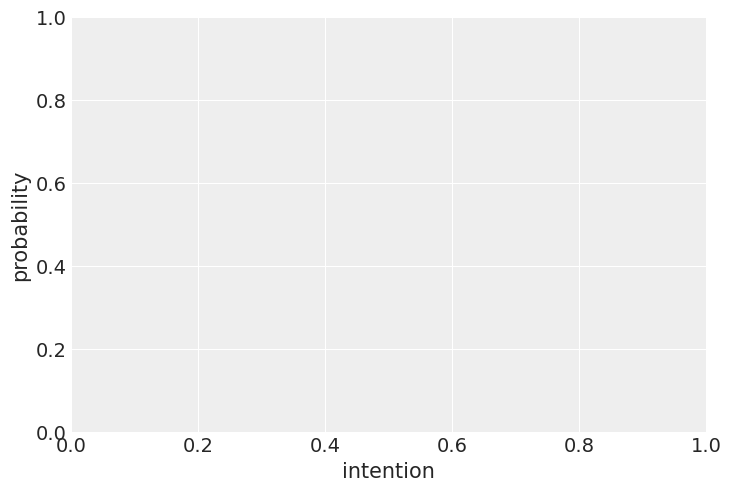

In [27]:
ax = plt.subplot(xlabel="intention", ylabel="probability", xlim=(0, 1), ylim=(0, 1))
fig = plt.gcf()

### Code 12.27

In [28]:
kA = 0  # value for action
kC = 0  # value for contact
kI = jnp.arange(2)  # values of intention to calculate over
pdat = dict(A=kA, C=kC, I=kI)
phi = Predictive(m12_5.sampler.model, m12_5.get_samples())(random.PRNGKey(1), **pdat)[
    "phi"
]

### Code 12.28

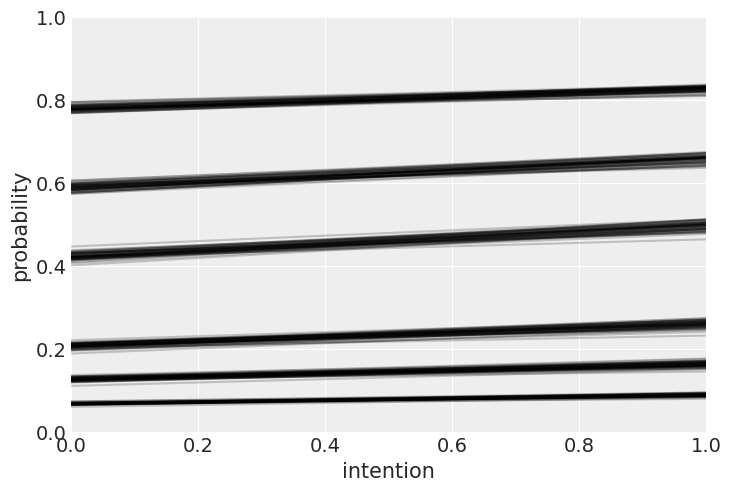

In [29]:
post = m12_5.get_samples()
for s in range(50):
    pk = expit(post["cutpoints"][s] - phi[s][..., None])
    for i in range(6):
        ax.plot(kI, pk[:, i], c="k", alpha=0.2)
fig

### Code 12.29

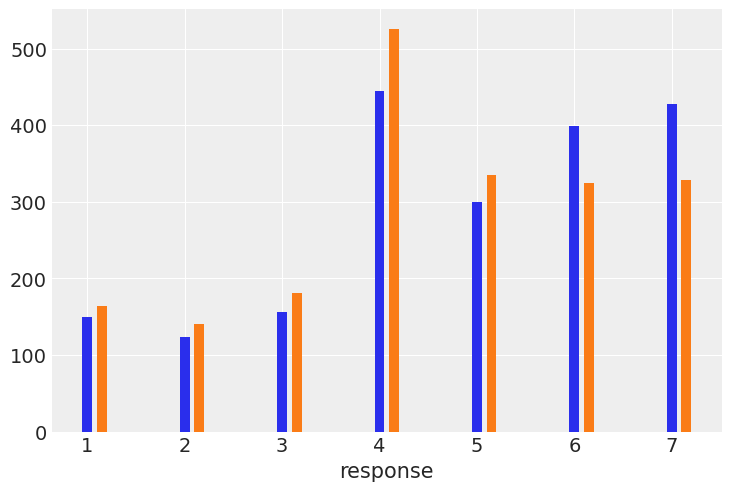

In [30]:
kA = 0  # value for action
kC = 0  # value for contact
kI = jnp.arange(2)  # values of intention to calculate over
pdat = dict(A=kA, C=kC, I=kI)
s = (
    Predictive(m12_5.sampler.model, m12_5.get_samples())(random.PRNGKey(1), **pdat)["R"]
    + 1
)
plt.hist(s[:, 0], bins=jnp.arange(0.5, 8), rwidth=0.1)
plt.hist(s[:, 1], bins=jnp.arange(0.65, 8), rwidth=0.1)
plt.gca().set(xlabel="response")
plt.show()

### Code 12.30

In [31]:
Trolley = pd.read_csv("../data/Trolley.csv", sep=";")
d = Trolley
d.edu.unique()

array(['Middle School', "Bachelor's Degree", 'Some College',
       "Master's Degree", 'High School Graduate', 'Graduate Degree',
       'Some High School', 'Elementary School'], dtype=object)

### Code 12.31

In [32]:
edu_levels = [
    "Elementary School",
    "Middle School",
    "Some High School",
    "High School Graduate",
    "Some College",
    "Bachelor's Degree",
    "Master's Degree",
    "Graduate Degree",
]
cat_type = pd.api.types.CategoricalDtype(categories=edu_levels, ordered=True)
d["edu_new"] = d.edu.astype(cat_type).cat.codes

### Code 12.32

In [33]:
delta = dist.Dirichlet(jnp.repeat(2, 7)).sample(random.PRNGKey(1805), (10,))
delta

DeviceArray([[0.03417401, 0.01293938, 0.25036842, 0.1575452 , 0.2428884 ,
              0.1542785 , 0.14780612],
             [0.03033227, 0.07930321, 0.10281111, 0.31324154, 0.23228963,
              0.08366161, 0.15836057],
             [0.01483982, 0.22535649, 0.22681098, 0.15501308, 0.06917012,
              0.13925819, 0.16955136],
             [0.07806947, 0.08031335, 0.20682837, 0.20677619, 0.05714671,
              0.24564272, 0.12522325],
             [0.11402585, 0.09701173, 0.29725808, 0.20345038, 0.05534748,
              0.1518271 , 0.08107934],
             [0.21828622, 0.10083836, 0.02636549, 0.09864605, 0.17023672,
              0.26219097, 0.12343625],
             [0.08793399, 0.40258408, 0.19680235, 0.04492018, 0.11284815,
              0.07903885, 0.07587239],
             [0.02919231, 0.14922367, 0.02290498, 0.11882434, 0.10678638,
              0.27817723, 0.29489112],
             [0.12048934, 0.1702906 , 0.13361444, 0.2657249 , 0.06682938,
              0.117910

### Code 12.33

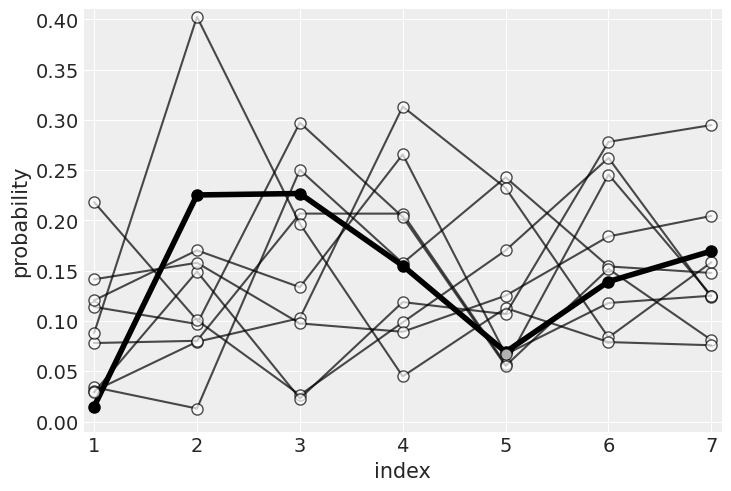

In [34]:
h = 3
plt.subplot(xlim=(0.9, 7.1), ylim=(-0.01, 0.41), xlabel="index", ylabel="probability")
for i in range(delta.shape[0]):
    if i + 1 == h:
        plt.plot(range(1, 8), delta[i], "ko-", ms=8, lw=4)
    else:
        plt.plot(range(1, 8), delta[i], "ko-", mfc="w", ms=8, lw=1.5, alpha=0.7)

### Code 12.34

In [35]:
dat = dict(
    R=d.response.values - 1,
    action=d.action.values,
    intention=d.intention.values,
    contact=d.contact.values,
    E=d.edu_new.values,  # edu_new as an index
    alpha=jnp.repeat(2, 7),
)  # delta prior


def model(action, intention, contact, E, alpha, R):
    bA = numpyro.sample("bA", dist.Normal(0, 1))
    bI = numpyro.sample("bI", dist.Normal(0, 1))
    bC = numpyro.sample("bC", dist.Normal(0, 1))
    bE = numpyro.sample("bE", dist.Normal(0, 1))
    delta = numpyro.sample("delta", dist.Dirichlet(alpha))
    kappa = numpyro.sample(
        "kappa",
        dist.TransformedDistribution(
            dist.Normal(jnp.zeros(6), 1.5), OrderedTransform()
        ),
    )
    delta_j = jnp.pad(delta, (1, 0))
    delta_E = jnp.sum(jnp.where(jnp.arange(8) <= E[..., None], delta_j, 0), -1)
    phi = bE * delta_E + bA * action + bI * intention + bC * contact
    numpyro.sample("R", dist.OrderedLogistic(phi, kappa), obs=R)


m12_6 = MCMC(NUTS(model), 500, 500, num_chains=3)
m12_6.run(random.PRNGKey(0), **dat)

### Code 12.35

In [36]:
m12_6.print_summary(0.89)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        bA     -0.70      0.04     -0.70     -0.77     -0.64   1085.85      1.00
        bC     -0.96      0.05     -0.96     -1.03     -0.87   1415.41      1.00
        bE     -0.38      0.19     -0.36     -0.66     -0.09    864.44      1.00
        bI     -0.72      0.04     -0.72     -0.78     -0.66   1898.26      1.00
  delta[0]      0.26      0.15      0.24      0.03      0.48   1106.16      1.00
  delta[1]      0.14      0.09      0.13      0.01      0.27   1982.16      1.00
  delta[2]      0.20      0.11      0.18      0.03      0.35   1540.92      1.00
  delta[3]      0.16      0.09      0.14      0.02      0.28   1445.86      1.00
  delta[4]      0.04      0.04      0.02      0.00      0.07    670.78      1.01
  delta[5]      0.09      0.06      0.08      0.01      0.17   1437.51      1.00
  delta[6]      0.12      0.07      0.11      0.01      0.21   1565.21      1.00
  kappa[0]     -3.13      0

### Code 12.36

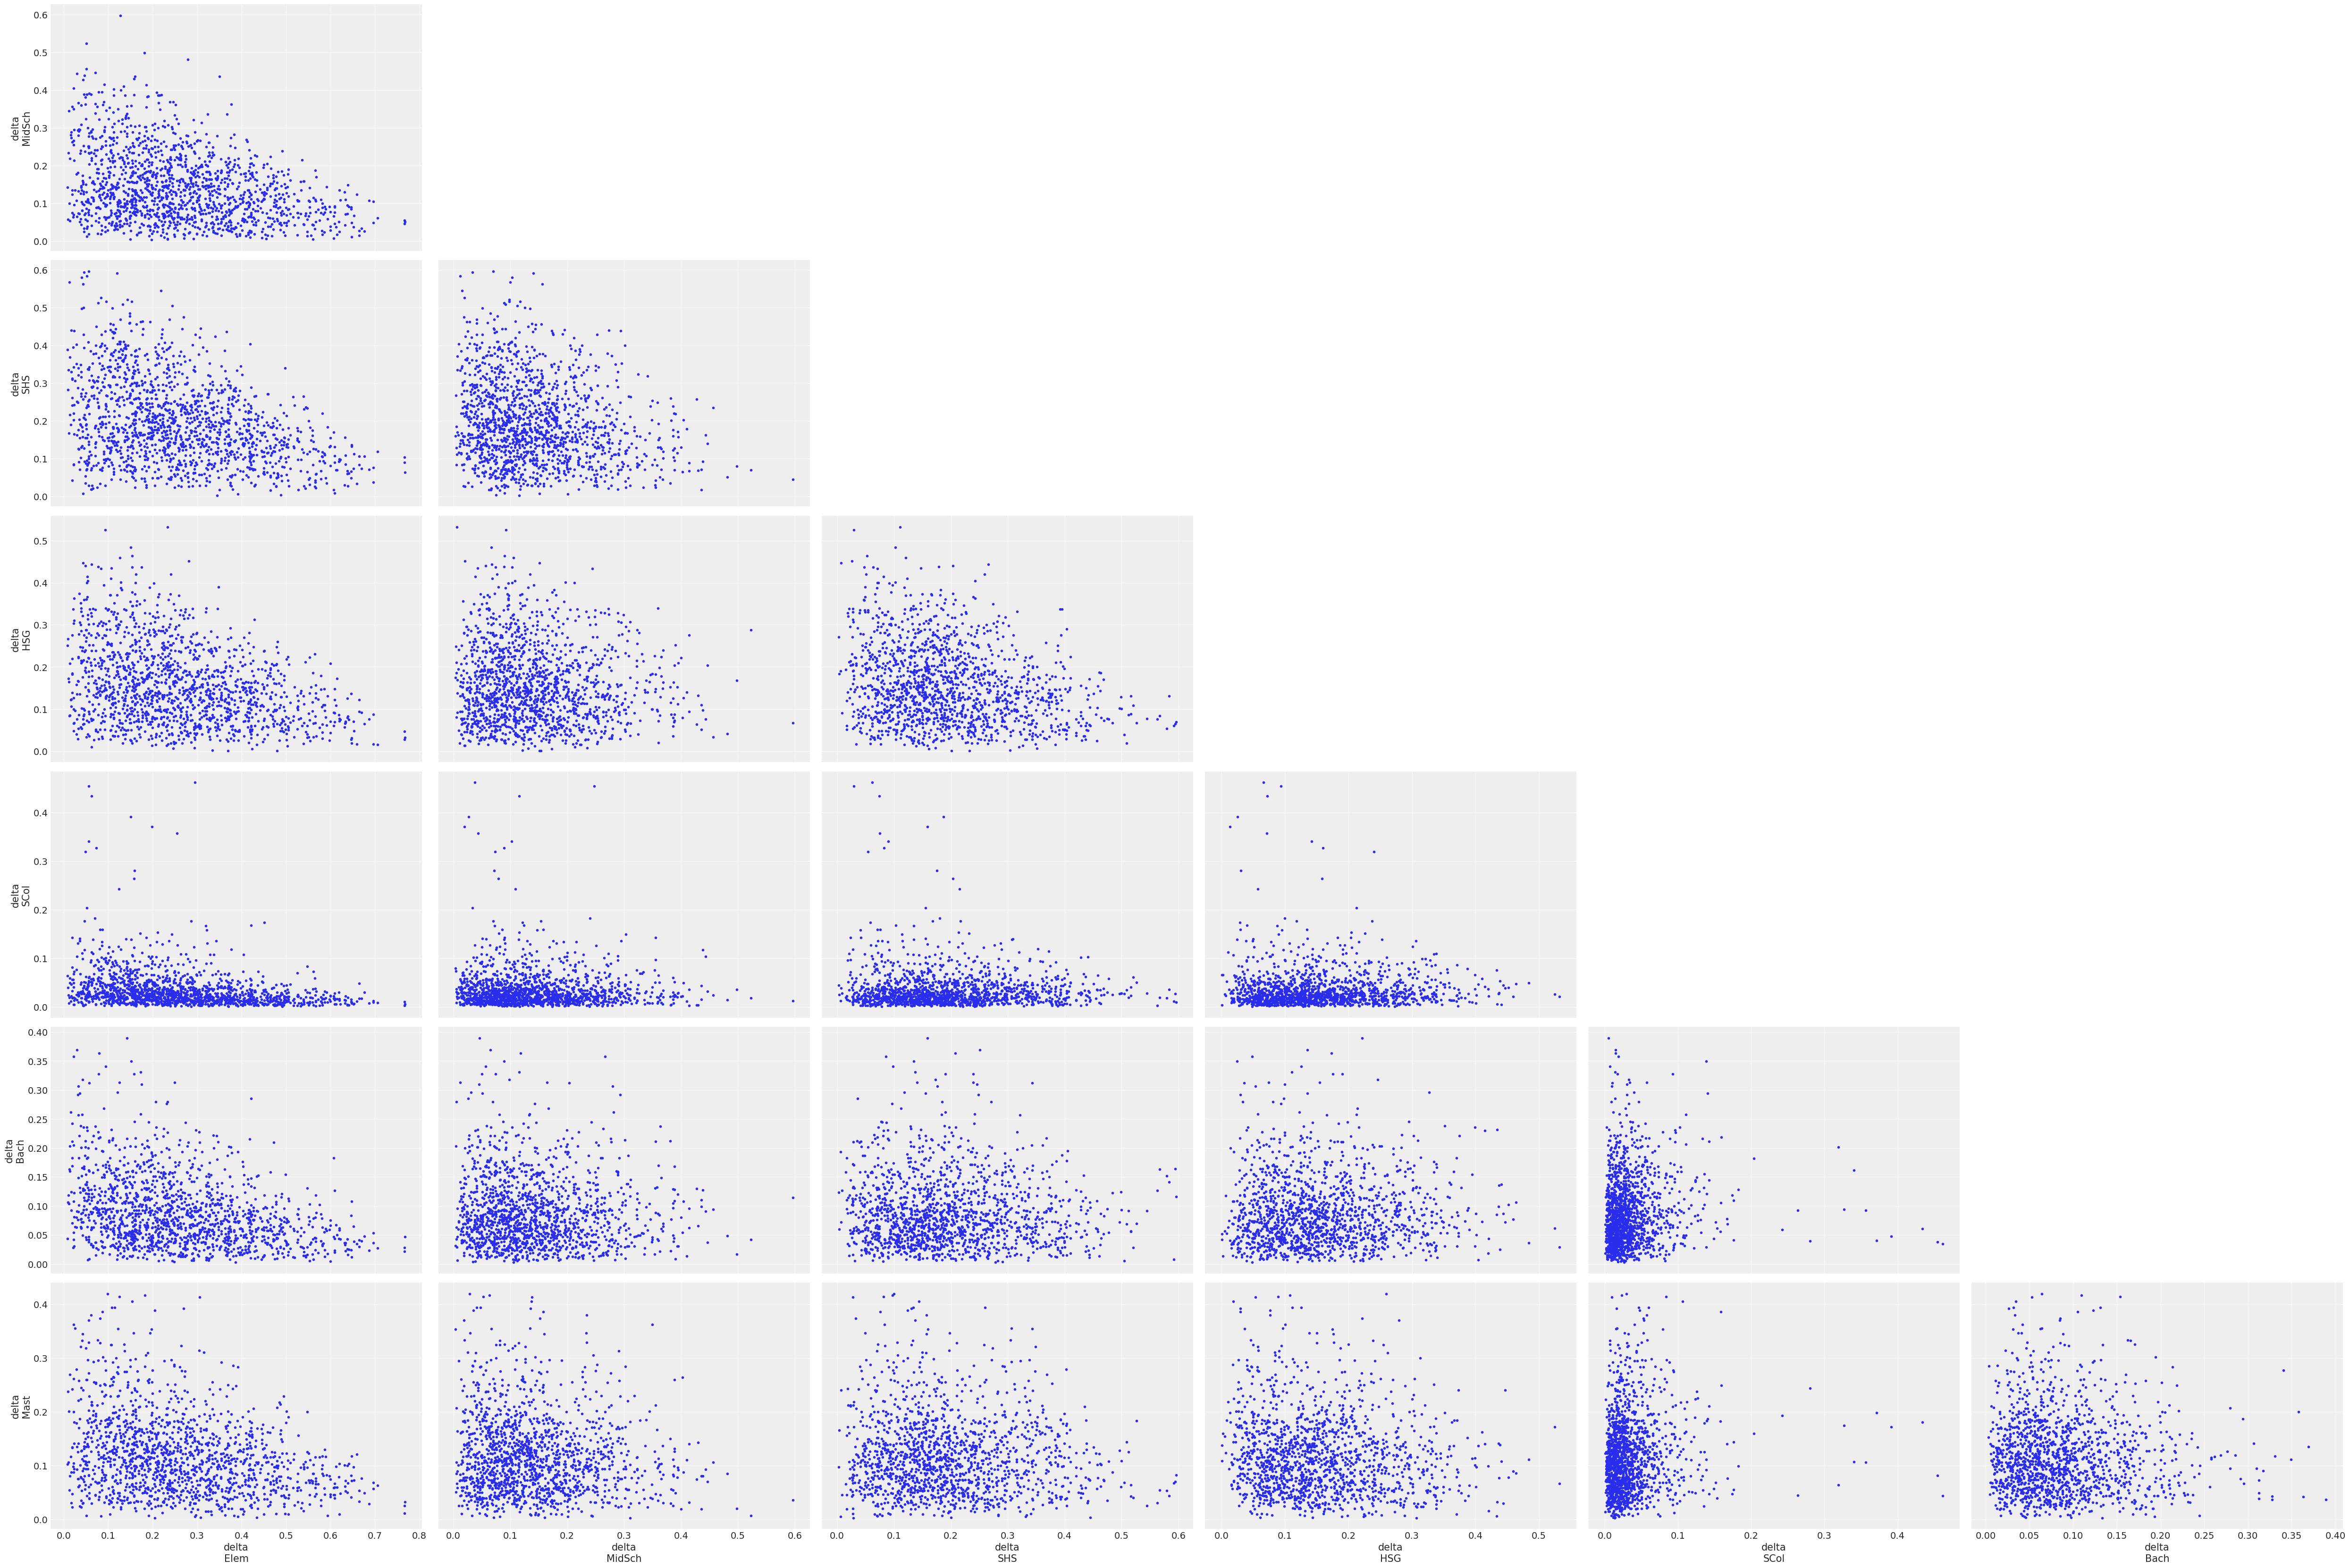

In [37]:
delta_labels = ["Elem", "MidSch", "SHS", "HSG", "SCol", "Bach", "Mast", "Grad"]
a12_6 = az.from_numpyro(
    m12_6, coords={"labels": delta_labels[:7]}, dims={"delta": ["labels"]}
)
az.plot_pair(a12_6, var_names="delta")
set_matplotlib_formats("png")

### Code 12.37

In [38]:
dat["edu_norm"] = d.edu_new.values / d.edu_new.max()


def model(edu_norm, action, intention, contact, y):
    bA = numpyro.sample("bA", dist.Normal(0, 1))
    bI = numpyro.sample("bI", dist.Normal(0, 1))
    bC = numpyro.sample("bC", dist.Normal(0, 1))
    bE = numpyro.sample("bE", dist.Normal(0, 1))
    cutpoints = numpyro.sample(
        "cutpoints",
        dist.TransformedDistribution(
            dist.Normal(jnp.zeros(6), 1.5), OrderedTransform()
        ),
    )
    mu = bE * edu_norm + bA * action + bI * intention + bC * contact
    numpyro.sample("y", dist.OrderedLogistic(mu, cutpoints), obs=y)


m12_7 = MCMC(NUTS(model), 500, 500, num_chains=3)
m12_7.run(
    random.PRNGKey(0),
    dat["edu_norm"],
    dat["action"],
    dat["intention"],
    dat["contact"],
    dat["R"],
)
m12_7.print_summary(0.89)


                  mean       std    median      5.5%     94.5%     n_eff     r_hat
          bA     -0.71      0.04     -0.71     -0.77     -0.65   1388.93      1.00
          bC     -0.96      0.05     -0.96     -1.04     -0.88   1330.84      1.00
          bE     -0.10      0.09     -0.11     -0.25      0.02   1189.00      1.00
          bI     -0.72      0.04     -0.72     -0.78     -0.66   1589.06      1.00
cutpoints[0]     -2.90      0.08     -2.90     -3.03     -2.79   1046.34      1.00
cutpoints[1]     -2.22      0.07     -2.22     -2.33     -2.10   1080.20      1.00
cutpoints[2]     -1.64      0.07     -1.64     -1.75     -1.52   1139.93      1.00
cutpoints[3]     -0.62      0.07     -0.62     -0.74     -0.52   1154.80      1.00
cutpoints[4]      0.05      0.07      0.05     -0.06      0.17   1152.86      1.00
cutpoints[5]      0.96      0.07      0.96      0.85      1.08   1160.22      1.00

Number of divergences: 0


### Code 12.38

In [39]:
Hurricanes = pd.read_csv("../data/Hurricanes.csv", sep=";")